In [3]:
import numpy as np
import os
from cellpose import models
from cellpose import utils as cp_utils
from cellstitch.pipeline import *
from cellstitch.evaluation import *
from cellstitch.utils import *
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Benchmark CellStitch Stitching
Generate unstitched 2D predictions:

In [2]:
cp_model_dir = './cellpose/train/models/cellpose_residual_on_style_on_concatenation_off_train_2022_08_30_13_18_51.543479'
flow_threshold = 1
model = models.Cellpose(gpu=True, model_type='cyto2')

In [4]:
filenames = get_filenames("../data/ovules/raw/")

In [ ]:
for filename in filenames: 
    img = np.load('../data/ovules/raw/%s' % filename)
    frames = list(img)
    unstitched, _, _, _ = model.eval(frames, flow_threshold=flow_threshold) 
    np.save('./results/unstitched/%s' % filename, np.array(unstitched))

Get the benchmark results for cellpose: 

In [6]:
thresholds = np.arange(0.1, 1, 0.1)

In [7]:
for threshold in thresholds:
    os.mkdir("./results/ovules/cp_stitched/%s" % threshold)

In [34]:
# cellpose benchmark
data = [] 
for filename in filenames:
    labels = np.load('../data/ovules/labels/%s' % filename) 
    true_num_cells = np.unique(labels).size - 1 
    true_avg_vol = get_avg_vol(labels) 
    
    for threshold in thresholds:
        unstitched = np.load('./results/ovules/unstitched/%s' % filename) 
        cp_stitched =  np.asarray(cp_utils.stitch3D(unstitched, stitch_threshold=threshold)) # compute stitched mask
        
        num_cells = np.unique(cp_stitched).size - 1
        d_num_cells = abs(num_cells - true_num_cells) / true_num_cells 
        
        avg_vol = get_avg_vol(cp_stitched)
        d_avg_vol = abs(true_avg_vol - avg_vol) / true_avg_vol
        
        ap, tp, fp, fn = average_precision(labels, cp_stitched, 0.75)
        
        row = [
            filename, 
            threshold, 
            d_num_cells, 
            d_avg_vol, 
            ap, 
            tp, 
            fp, 
            fn
        ]
        print(row)
        data.append(row)

['N_422_ds2x.npy', 0.1, 0.06931818181818182, 0.06760139257934254, 0.139549436795995, 223, 718, 657]
['N_422_ds2x.npy', 0.2, 0.19090909090909092, 0.16279857864232963, 0.13411764705882354, 228, 820, 652]
['N_422_ds2x.npy', 0.30000000000000004, 0.3090909090909091, 0.23837926251489708, 0.13392857142857142, 240, 912, 640]
['N_422_ds2x.npy', 0.4, 0.45227272727272727, 0.31346863099934386, 0.12748171368861025, 244, 1034, 636]
['N_422_ds2x.npy', 0.5, 0.6977272727272728, 0.4127261783247399, 0.1171764705882353, 249, 1245, 631]
['N_422_ds2x.npy', 0.6, 1.1568181818181817, 0.5377307220322242, 0.1041335453100159, 262, 1636, 618]
['N_422_ds2x.npy', 0.7000000000000001, 1.9613636363636364, 0.6633203800526329, 0.08126550868486353, 262, 2344, 618]
['N_422_ds2x.npy', 0.8, 3.8840909090909093, 0.7958615426750026, 0.043320572234535566, 215, 4083, 665]
['N_422_ds2x.npy', 0.9, 10.60909090909091, 0.9141163772922045, 0.002711006687149828, 30, 10186, 850]
['N_457_ds2x.npy', 0.1, 1.8117283950617284, 0.6092513678647

['N_445_ds2x.npy', 0.6, 6.1901944209636515, 0.8759605550773107, 0.03503899156073069, 328, 8178, 855]
['N_445_ds2x.npy', 0.7000000000000001, 8.035502958579881, 0.9012929629981855, 0.026634382566585957, 308, 10381, 875]
['N_445_ds2x.npy', 0.8, 11.596787827557058, 0.9291987975766746, 0.011507986416802918, 183, 14719, 1000]
['N_445_ds2x.npy', 0.9, 20.196111580726967, 0.9579230501091767, 0.00030476190476190474, 8, 25067, 1175]
['N_517_ds2x.npy', 0.1, 7.882829771554901, 0.9246646598651946, 0.007966929725667043, 106, 11948, 1251]
['N_517_ds2x.npy', 0.2, 9.15033161385409, 0.9340720059543384, 0.007121938232161874, 107, 13667, 1250]
['N_517_ds2x.npy', 0.30000000000000004, 10.538688282977155, 0.9420045861550043, 0.006506950606329488, 110, 15548, 1247]
['N_517_ds2x.npy', 0.4, 12.148120854826823, 0.9491036772791759, 0.00613143276386123, 117, 17725, 1240]
['N_517_ds2x.npy', 0.5, 13.910095799557848, 0.9551182627398338, 0.00671453884174205, 144, 20089, 1213]
['N_517_ds2x.npy', 0.6, 15.898305084745763,

['N_511_final_crop_ds2.npy', 0.2, 0.277516462841016, 0.2454939602534885, 0.125, 269, 1089, 794]
['N_511_final_crop_ds2.npy', 0.30000000000000004, 0.3951081843838194, 0.3090902211896408, 0.12010558732952045, 273, 1210, 790]
['N_511_final_crop_ds2.npy', 0.4, 0.5832549388523048, 0.39119477006787723, 0.1126418152350081, 278, 1405, 785]
['N_511_final_crop_ds2.npy', 0.5, 0.883349012229539, 0.4882021968153034, 0.10930148389431778, 302, 1700, 761]
['N_511_final_crop_ds2.npy', 0.6, 1.3734713076199436, 0.5938885445993807, 0.09966268015946028, 325, 2198, 738]
['N_511_final_crop_ds2.npy', 0.7000000000000001, 2.239887111947319, 0.702491520912961, 0.07797177708682133, 326, 3118, 737]
['N_511_final_crop_ds2.npy', 0.8, 3.9642521166509876, 0.8058330108061847, 0.04224889035015617, 257, 5020, 806]
['N_511_final_crop_ds2.npy', 0.9, 9.381937911571026, 0.9071566507814641, 0.00448318804483188, 54, 10982, 1009]
['N_512_ds2x.npy', 0.1, 8.34980694980695, 0.8953121732810397, 0.008199187603430119, 109, 11999, 118

['N_404_ds2x.npy', 0.7000000000000001, 19.42406311637081, 0.9290900896324503, 0.003974489324336815, 43, 10312, 464]
['N_404_ds2x.npy', 0.8, 25.443786982248522, 0.9452321830494534, 0.0016557483262544094, 23, 13384, 484]
['N_404_ds2x.npy', 0.9, 40.56804733727811, 0.9651590926758729, 0.0, 0, 21075, 507]
['N_458_ds2x.npy', 0.1, 1.0814977973568283, 0.4625841998870212, 0.029433406916850625, 40, 905, 414]
['N_458_ds2x.npy', 0.2, 1.2356828193832599, 0.49964735851550257, 0.028711484593837534, 41, 974, 413]
['N_458_ds2x.npy', 0.30000000000000004, 1.4559471365638768, 0.5445220348818252, 0.03155818540433925, 48, 1067, 406]
['N_458_ds2x.npy', 0.4, 1.722466960352423, 0.5891117062243002, 0.03048780487804878, 50, 1186, 404]
['N_458_ds2x.npy', 0.5, 2.2709251101321586, 0.6580081272008317, 0.028647214854111407, 54, 1431, 400]
['N_458_ds2x.npy', 0.6, 3.1784140969162995, 0.7322836420101397, 0.026189436927106065, 60, 1837, 394]
['N_458_ds2x.npy', 0.7000000000000001, 4.830396475770925, 0.8081382957662392, 0.

In [35]:
cp_df = pd.DataFrame(data, columns=[
    "filename", 
    "threshold", 
    "d_num_cells", 
    "d_avg_vol", 
    "ap", 
    "tp", 
    "fp", 
    "rn"
])

In [37]:
cp_df.to_csv("cp_stitching_benchmark.csv", index=False)

In [11]:
# cellmatch benchmark
data = [] 
for filename in filenames:
    print("Starting %s" % filename)
    labels = np.load('../data/ovules/labels/%s' % filename)
    true_num_cells = np.unique(labels).size - 1 
    true_avg_vol = get_avg_vol(labels) 
    
    ct_stitched = np.load('./results/ovules/ct_stitched/%s' % filename) 
    
    num_cells = np.unique(ct_stitched).size - 1
    d_num_cells = abs(num_cells - true_num_cells) / true_num_cells

    avg_vol = get_avg_vol(ct_stitched)
    d_avg_vol = abs(true_avg_vol - avg_vol) / true_avg_vol

    ap, tp, fp, fn = average_precision(labels, ct_stitched, 0.75)
    
    row = [ 
        filename, 
        d_num_cells, 
        d_avg_vol, 
        ap, 
        tp, 
        fp, 
        fn
    ]
    
    print(row)
    data.append(row)

Starting N_422_ds2x.npy
['N_422_ds2x.npy', 0.11931818181818182, 0.12965549166458099, 0.15815255423372987, 226, 549, 654]
Starting N_457_ds2x.npy
['N_457_ds2x.npy', 0.7253086419753086, 0.36771273361212686, 0.07355623100303951, 121, 997, 527]
Starting N_590_final_crop_ds2.npy
['N_590_final_crop_ds2.npy', 0.9337606837606838, 0.6697040600739687, 0.01141804788213628, 31, 1779, 905]
Starting N_405_B_ds2x.npy
['N_405_B_ds2x.npy', 0.4891304347826087, 0.08109501229979045, 0.11489776046738072, 118, 567, 342]
Starting N_522_final_crop_ds2.npy
['N_522_final_crop_ds2.npy', 3.550046772684752, 0.8693679519470305, 0.007129519606178917, 42, 4822, 1027]
Starting N_464_ds2x.npy
['N_464_ds2x.npy', 2.494661921708185, 0.8496000183069649, 0.01786433848220282, 133, 5759, 1553]
Starting N_534_ds2x.npy
['N_534_ds2x.npy', 2.3603286384976525, 0.8879386473820348, 0.0031051707843931416, 23, 5703, 1681]
Starting N_454_ds2x.npy
['N_454_ds2x.npy', 3.3403314917127074, 0.4693523503142204, 0.003738317757009346, 36, 7820,

In [12]:
ct_df = pd.DataFrame(data, columns=[
    "filename", 
    "d_num_cells", 
    "d_avg_vol", 
    "ap", 
    "tp", 
    "fp", 
    "rn"
])

In [13]:
ct_df.to_csv("ct_stitching_benchmark.csv", index=False)

# Analyze Results

Number of cells and average volume.

In [116]:
cp_df = pd.read_csv("cp_stitching_benchmark.csv")
ct_df = pd.read_csv("ct_stitching_benchmark.csv")

In [117]:
col_name = 'd_num_cells'

In [118]:
cp_best_df = cp_df.groupby(['filename']).min()[col_name]
cp_best_df = cp_best_df.reset_index()
cp_best_df = cp_best_df.drop(columns=['filename'])
cp_all_df = cp_df[col_name]
cp_all_df = cp_all_df.reset_index()
cp_all_df = cp_all_df.drop(columns=['index'])
ct_df = ct_df[col_name]
ct_df = ct_df.reset_index()
ct_df = ct_df.drop(columns=['index'])
cp_best_df['method'] = 'cellpose_best'
cp_all_df['method'] = 'cellpose_all'
ct_df['method'] = 'cellstitch'
df = pd.concat([cp_best_df, cp_all_df, ct_df])

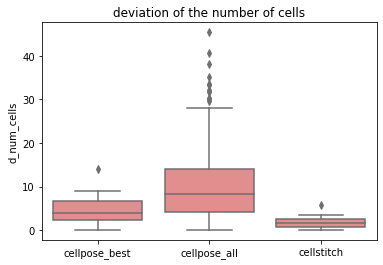

In [119]:
ax = sns.boxplot(data=df, x="method", y=col_name, color="lightcoral")
plt.title("deviation of the number of cells")
ax.set(xlabel=None)
plt.savefig('./figures/%s.png' % col_name)

Average precision. 

In [105]:
cp_df = pd.read_csv("cp_stitching_benchmark.csv")
ct_df = pd.read_csv("ct_stitching_benchmark.csv")

In [106]:
col_name = 'ap'

In [107]:
cp_best_df = cp_df.groupby(['filename']).max()[col_name]
cp_best_df = cp_best_df.reset_index()
cp_best_df = cp_best_df.drop(columns=['filename'])
cp_all_df = cp_df[col_name]
cp_all_df = cp_all_df.reset_index()
cp_all_df = cp_all_df.drop(columns=['index'])
ct_df = ct_df[col_name]
ct_df = ct_df.reset_index()
ct_df = ct_df.drop(columns=['index'])
cp_best_df['method'] = 'cellpose_best'
cp_all_df['method'] = 'cellpose_all'
ct_df['method'] = 'cellstitch'
df = pd.concat([cp_best_df, cp_all_df, ct_df])

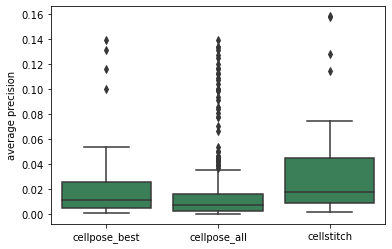

In [111]:
ax = sns.boxplot(data=df, x="method", y=col_name, color="seagreen")
ax.set(xlabel=None)
ax.set(ylabel='average precision')
plt.savefig('./figures/%s.png' % col_name)